In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
from stock_features import get_stock_data, get_key_features, get_feature_sets
# 1. set up the parameters
ticker = "AAPL"
start_date = "2021-01-01"
end_date = "2025-01-01"

# 2. get the stock data
print("📥 Fetching stock data...")
data = get_stock_data(ticker, start_date, end_date, interval="1d")
features_df = get_key_features(data)
print("✅ Received stock data!")

# 3. get the feature sets
feature_sets = get_feature_sets()

[*********************100%***********************]  1 of 1 completed

📥 Fetching stock data...
✅ Received stock data!


In [ ]:
from market_states import get_transition_matrices
# 4. get the transition matrices
transmat_options = get_transition_matrices(features_df)

In [ ]:
# 5. train and evaluate the model
results = []

from train_eval import kfold_evaluate_model
for feature_set in feature_sets:
    try:
        
        missing_features = [feat for feat in feature_set if feat not in features_df.columns]
        if missing_features:
            print(f"Warning: Missing features {missing_features}, skipping...")
            continue
        
        features = features_df[feature_set].ffill().bfill().copy()
        # print("Any NaN in features?", np.isnan(features).sum())

        for transmat_name, transmat in transmat_options.items():
            try:
                model, states, mean_score, std_score = kfold_evaluate_model(features, transmat, n_splits=5)
                
                results.append({
                    "Feature_Set": feature_set,
                    "Transition": transmat_name,
                    "KFold_Mean_Score": mean_score,
                    "KFold_Std_Dev": std_score
                })
                
            except Exception as e:
                print(f"Error with {transmat_name}: {str(e)}")
    except Exception as e:
        print(f"Error with feature set {feature_set}: {str(e)}")

# 6. display the results
results_df = pd.DataFrame(results)
print("\n📊 Model Evaluation Results:")
print(results_df)


🚀 Starting model evaluation...

📊 Model Evaluation Results:
                         Feature_Set   Transition  KFold_Mean_Score  \
0                            [Close]      Default       -184.602593   
1                            [Close]      Uniform       -117.947286   
2                            [Close]   Persistent        -98.225366   
3                            [Close]  State-Based        -98.226024   
4                           [Volume]      Default       -225.732127   
..                               ...          ...               ...   
67  [MA200, MACD, MACD_Signal, MA50]  State-Based       -816.513757   
68   [MA200, Daily_Return, ATR, RSI]      Default       -993.514808   
69   [MA200, Daily_Return, ATR, RSI]      Uniform       -917.016053   
70   [MA200, Daily_Return, ATR, RSI]   Persistent       -920.123713   
71   [MA200, Daily_Return, ATR, RSI]  State-Based       -920.124040   

    KFold_Std_Dev  
0        8.757336  
1        5.305668  
2        6.930866  
3      

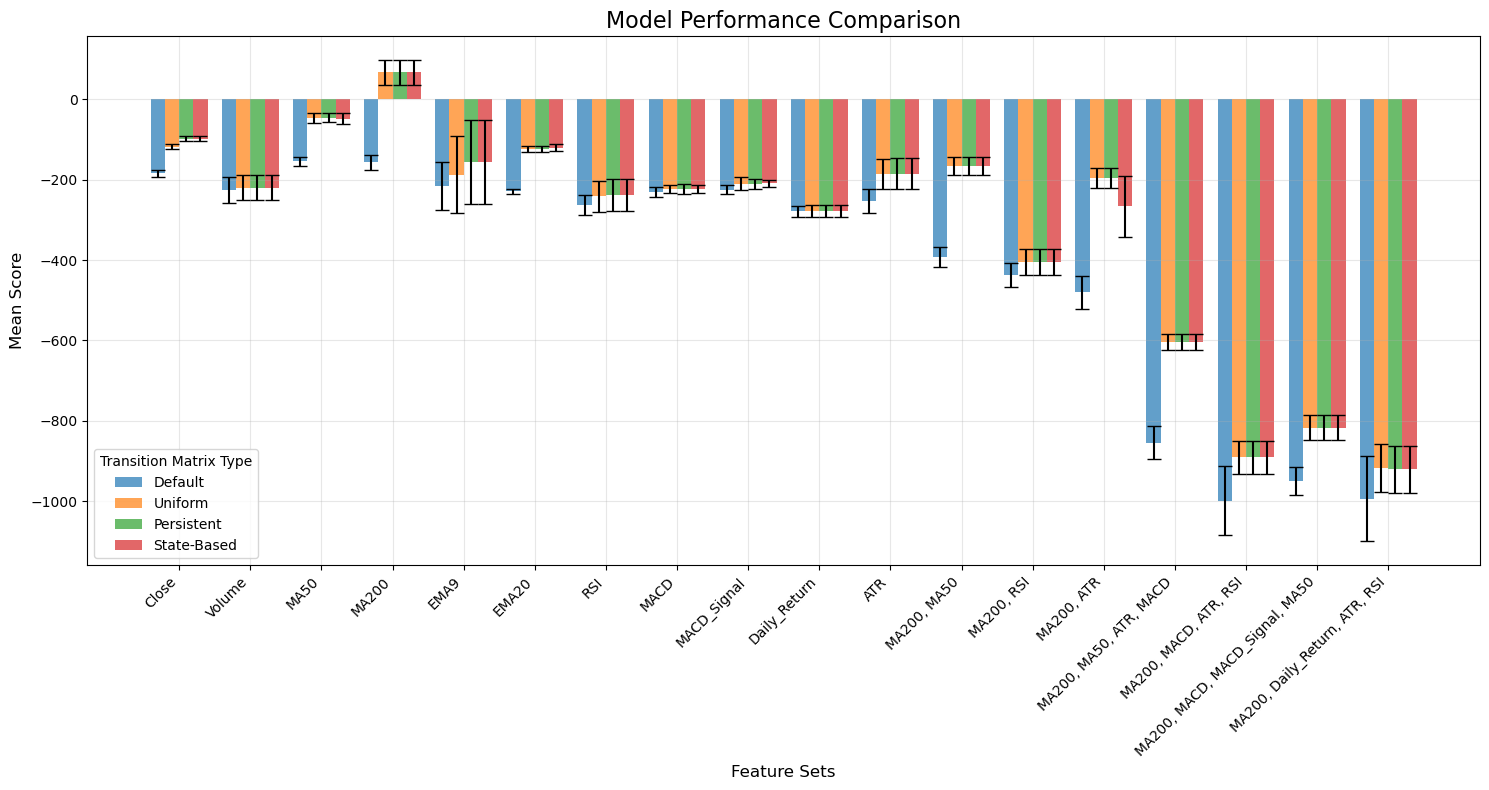

In [ ]:
# 7. visualize the results
from visualization import plot_model_results 

fig = plot_model_results(results_df)
plt.show()
plt.close()

In [ ]:
ma200_scores = results_df[results_df['Feature_Set'].apply(lambda x: x == ['MA200'])]
print("MA200:")
print(ma200_scores)


MA200:
   Feature_Set   Transition  KFold_Mean_Score  KFold_Std_Dev
12     [MA200]      Default       -157.253251      18.826409
13     [MA200]      Uniform         66.249100      30.105644
14     [MA200]   Persistent         66.249100      30.105641
15     [MA200]  State-Based         66.249102      30.105642


### Key Findings:

1. MA200 emerged as the strongest single feature:
- Performed best among all single features
- Got positive scores with all transition matrix types
- Stayed stable no matter which transition matrix (expect for default matrix) we used

2. Transition Matrix Impact:
- The model showed interesting behavior with MA200
- Uniform, Persistent, and State-Based matrices got very similar results
- Default matrix showed slightly different behavior, maybe because of overfitting

3. Feature Combination Insights:
- Simple features worked better than complex ones
- Adding more features actually decreased model performance in most cases
- This suggests that the HMM might be more effective with cleaner, less noisy signals
